# Importing all necessary modules

In [205]:
# Basic libraries
import pandas as pd
import numpy as np
# import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import collections

# Others
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, make_scorer, roc_curve, confusion_matrix
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV, cross_val_predict
import itertools
import warnings
warnings.filterwarnings("ignore")

# Understanding the data

We are going to use credit card transaction data which has been modified to protect the sensitive information. Instead of using the real features, the data contains PCA transformed features. In addition to 28 PCA features, we also have two features that were not transformed and these are: time and amount. 

Time: the seconds elapsed between each transaction and the first transaction in the dataset <br>
Amount: amount of the transaction.

The response variable is mentioned in the column called "Class" which takes value 1 if the transaction was a fraud transaction otherwise it takes value 0.

In [72]:
df = pd.read_csv("./data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [73]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [74]:
null_num = df.isnull().sum().max()
print("Total null values in the dataframe: {}".format(null_num))

Total null values in the dataframe: 0


In [75]:
print("Positive class (fraud transactions) are {0:.2f}% of the dataset".format(100*df["Class"].value_counts()[1]/len(df)))

Positive class (fraud transactions) are 0.17% of the dataset


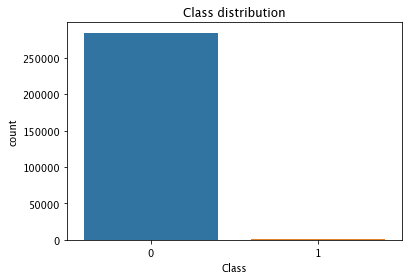

In [76]:
sns.countplot(x="Class", data = df)
plt.title("Class distribution")
plt.show()

**Note**: We can see that the classes are highly imbalanced with majority of the transactions belong to non-fraud class. 

We will check the distribution of other two known features, Time and the amount spent. 

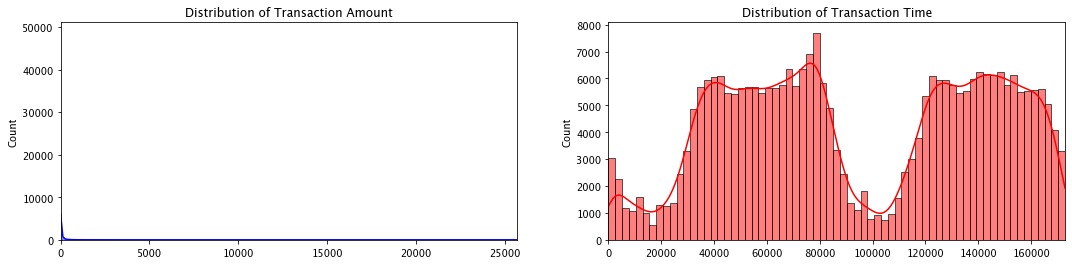

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amounts = df["Amount"].values
times = df["Time"].values

sns.histplot(amounts, ax=ax[0], color='b', kde=True)
ax[0].set_title("Distribution of Transaction Amount")
ax[0].set_xlim([min(amounts), max(amounts)])

sns.histplot(times, ax=ax[1], color='r', kde=True)
ax[1].set_title("Distribution of Transaction Time")
ax[1].set_xlim([min(times), max(times)])

plt.show()

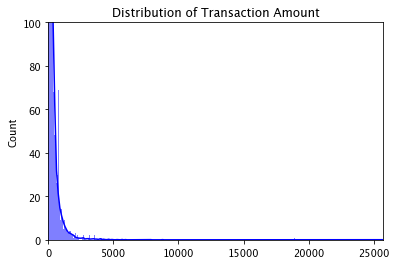

In [78]:
sns.histplot(amounts, color='b', kde=True)
plt.title("Distribution of Transaction Amount")
plt.xlim([min(amounts), max(amounts)])
plt.ylim([0, 100])
plt.show()

## Observations:

* Most of the transactions are small in amount with median amount being USD 88. 
* There are no NULL values in the data.
* Positive class represents only 0.17% of the dataset indicating highly imbalanced data.

# Feature Scaling and transformation:
Time and Amount column range needs to be scaled for most of our prediction algorithms. That is why we will use RobustScaler as it robust to the outliers.

In [79]:
scaler = RobustScaler()

df["amount_scaled"] = scaler.fit_transform(df["Amount"].values.reshape(-1, 1))
df["time_scaled"] = scaler.fit_transform(df["Time"].values.reshape(-1, 1))
df.drop(["Time", "Amount"], axis=1, inplace=True)

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,amount_scaled,time_scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


## Performing random under sampling

In [80]:
print("Total number of fraud and non-fraud samples are:")
print(df["Class"].value_counts())

Total number of fraud and non-fraud samples are:
0    284315
1       492
Name: Class, dtype: int64


In [81]:
# shuffle the data
df = df.sample(frac=1)

# 492 fraud cases in total
df_fraud = df.loc[df["Class"]==1]
df_non_fraud = df.loc[df["Class"]==0][:492]

new_usmpl_df = pd.concat([df_fraud, df_non_fraud])
new_usmpl_df = new_usmpl_df.sample(frac=1, random_state=42)

new_usmpl_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,amount_scaled,time_scaled
145466,-0.826875,0.633387,1.677595,-0.310517,0.467274,-0.695738,0.784451,-0.147211,-0.311738,-1.009854,...,0.289221,-0.367555,0.091105,0.741097,-0.140470,0.043344,0.071183,0,0.123804,0.026798
77099,-0.075483,1.812355,-2.566981,4.127549,-1.628532,-0.805895,-3.390135,1.019353,-2.451251,-3.555835,...,0.270471,-0.143624,0.013566,0.634203,0.213693,0.773625,0.387434,1,-0.237546,-0.326660
133814,1.282006,0.400797,0.144938,0.906374,0.156033,-0.375118,0.196829,-0.217044,-0.107713,-0.047192,...,-0.167126,-0.145542,-0.421579,0.701169,-0.392421,0.029691,0.021297,0,-0.167680,-0.048779
124036,-0.715414,0.608590,1.155501,-0.267565,-0.563748,-0.618898,0.698308,0.069837,-0.133341,-1.025335,...,0.239389,-0.090227,0.411572,-0.216126,0.353896,-0.062361,0.008433,1,1.495144,-0.088558
212644,-2.356348,1.746360,-6.374624,1.772205,-3.439294,1.457811,-0.362577,1.443791,-1.927359,-6.564659,...,0.621203,0.964817,-0.619437,-1.732613,0.108361,1.130828,0.415703,1,9.863900,0.637343


In [82]:
print("Total number of fraud and non-fraud samples after under-sampling are:")
new_usmpl_df["Class"].value_counts()

Total number of fraud and non-fraud samples after under-sampling are:


0    492
1    492
Name: Class, dtype: int64

### Checking correlation among features:

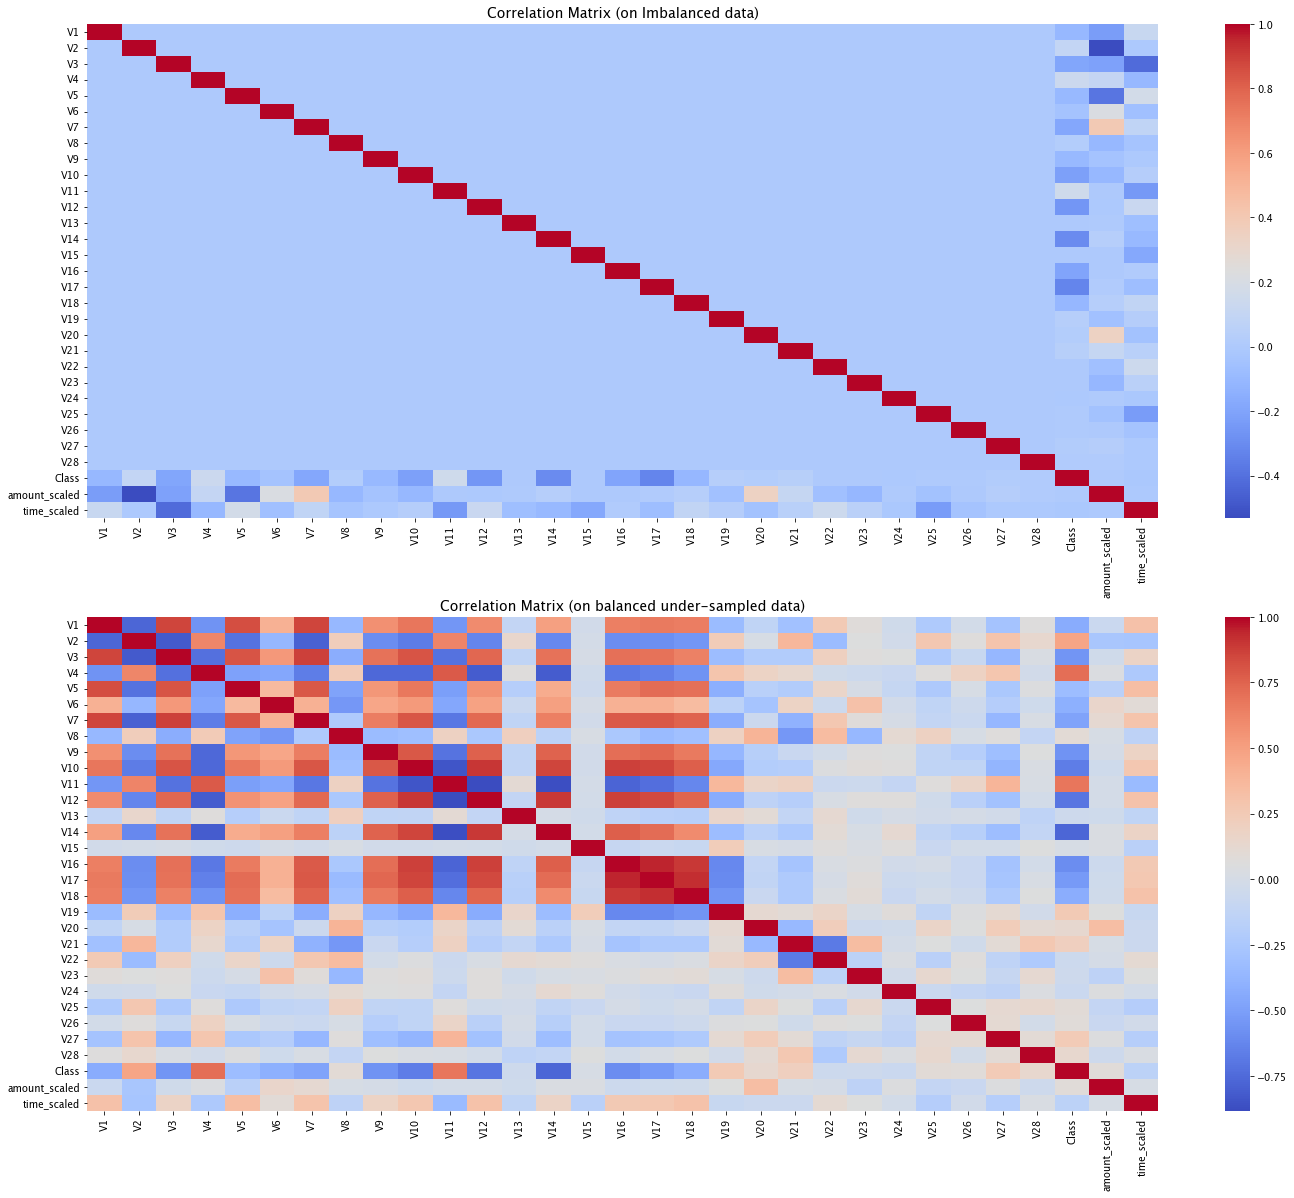

In [238]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 20))

# creating the correlation matrix for the originial df
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Correlation Matrix (on Imbalanced data)", fontsize=14)

# creating the correlation matrix for the under-sampled dataframe
corr = new_usmpl_df.corr()
sns.heatmap(corr, cmap='coolwarm', annot_kws={'size':20}, ax=ax2)
ax2.set_title("Correlation Matrix (on balanced under-sampled data)", fontsize=14)

plt.show()

**Observation:**

* Positive correlation: Features V2, V4, V11 and V19 seem to have high positive correlation with the target variable.
* Negative correlation: Features V10, V12, V14 and V16 seem to have high positive correlation with the target variable.

We will try to visualize these features separately for fradulent and non-fradulent cases using box-plots.

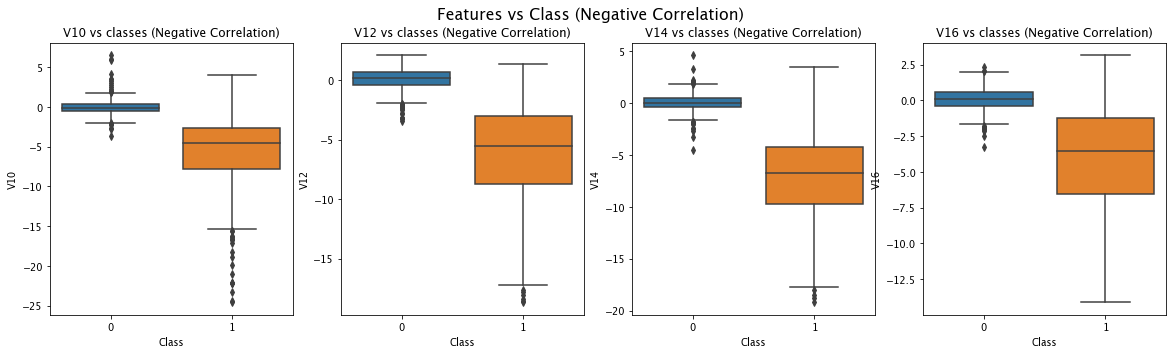

In [84]:
# Negative correlation box plots
f, ax = plt.subplots(ncols=4, figsize=(20,5))

sns.boxplot(x="Class", y="V10", data=new_usmpl_df, ax=ax[0])
ax[0].set_title("V10 vs classes (Negative Correlation)")

sns.boxplot(x="Class", y="V12", data=new_usmpl_df, ax=ax[1])
ax[1].set_title("V12 vs classes (Negative Correlation)")

sns.boxplot(x="Class", y="V14", data=new_usmpl_df, ax=ax[2])
ax[2].set_title("V14 vs classes (Negative Correlation)")

sns.boxplot(x="Class", y="V16", data=new_usmpl_df, ax=ax[3])
ax[3].set_title("V16 vs classes (Negative Correlation)")

f.suptitle("Features vs Class (Negative Correlation)", fontsize=16)
plt.show()

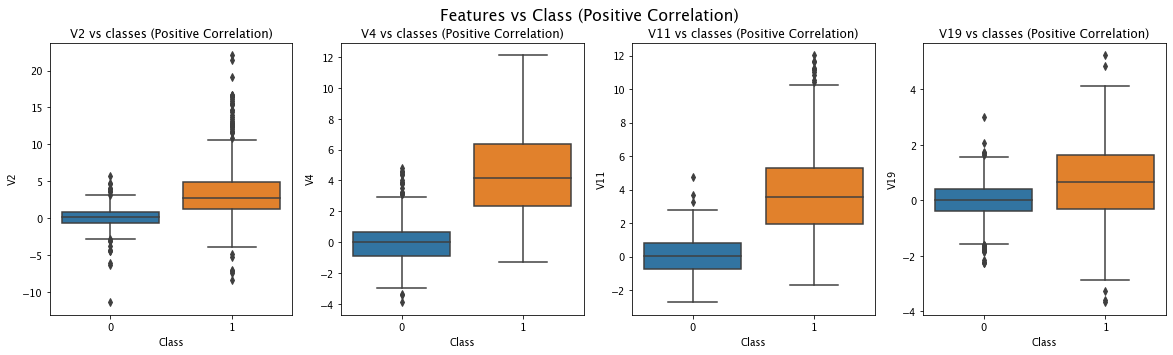

In [85]:
# Positive correlation box plots
f, ax = plt.subplots(ncols=4, figsize=(20,5))

sns.boxplot(x="Class", y="V2", data=new_usmpl_df, ax=ax[0])
ax[0].set_title("V2 vs classes (Positive Correlation)")

sns.boxplot(x="Class", y="V4", data=new_usmpl_df, ax=ax[1])
ax[1].set_title("V4 vs classes (Positive Correlation)")

sns.boxplot(x="Class", y="V11", data=new_usmpl_df, ax=ax[2])
ax[2].set_title("V11 vs classes (Positive Correlation)")

sns.boxplot(x="Class", y="V19", data=new_usmpl_df, ax=ax[3])
ax[3].set_title("V19 vs classes (Positive Correlation)")

f.suptitle("Features vs Class (Positive Correlation)", fontsize=16)
plt.show()

### Removing the outliers from the highly correlated features:

In [86]:
print("Total samples before removing outliers: {}".format(len(new_usmpl_df)))

# Removing outliers from V14
v14_fraud = new_usmpl_df["V14"].loc[new_usmpl_df["Class"]==1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
v14_iqr = q75 - q25
v14_cutoff = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cutoff, q75 + v14_cutoff
outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print("Total number of outliers for feature V14: {}".format(len(outliers)))
new_usmpl_df = new_usmpl_df.drop(new_usmpl_df[(new_usmpl_df["V14"] > v14_upper) | (new_usmpl_df["V14"] < v14_lower)].index)

# Removing outliers from V10
v10_fraud = new_usmpl_df["V10"].loc[new_usmpl_df["Class"]==1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25
v10_cutoff = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cutoff, q75 + v10_cutoff
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print("Total number of outliers for feature v10: {}".format(len(outliers)))
new_usmpl_df = new_usmpl_df.drop(new_usmpl_df[(new_usmpl_df["V10"] > v10_upper) | (new_usmpl_df["V10"] < v10_lower)].index)

# Removing outliers from V12
v12_fraud = new_usmpl_df["V12"].loc[new_usmpl_df["Class"]==1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25
v12_cutoff = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cutoff, q75 + v12_cutoff
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print("Total number of outliers for feature V12: {}".format(len(outliers)))
new_usmpl_df = new_usmpl_df.drop(new_usmpl_df[(new_usmpl_df["V12"] > v12_upper) | (new_usmpl_df["V12"] < v12_lower)].index)

print("Total samples after removing outliers: {}".format(len(new_usmpl_df)))

Total samples before removing outliers: 984
Total number of outliers for feature V14: 4
Total number of outliers for feature v10: 25
Total number of outliers for feature V12: 15
Total samples after removing outliers: 936


## Dimensionality reduction to see the separation between classes:

### t-SNE algorithm:

In [87]:
X = new_usmpl_df.drop("Class", axis=1)
y = new_usmpl_df["Class"]

# t-SNE starts here
tsne_start = time.time()
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
tsne_end = time.time()
print("Time taken for t-SNE: {}".format(tsne_end - tsne_start))

# PCA algo
pca_start = time.time()
X_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
pca_end = time.time()
print("Time taken for PCA: {}".format(pca_end - pca_start))


Time taken for t-SNE: 2.5884859561920166
Time taken for PCA: 1.5644879341125488


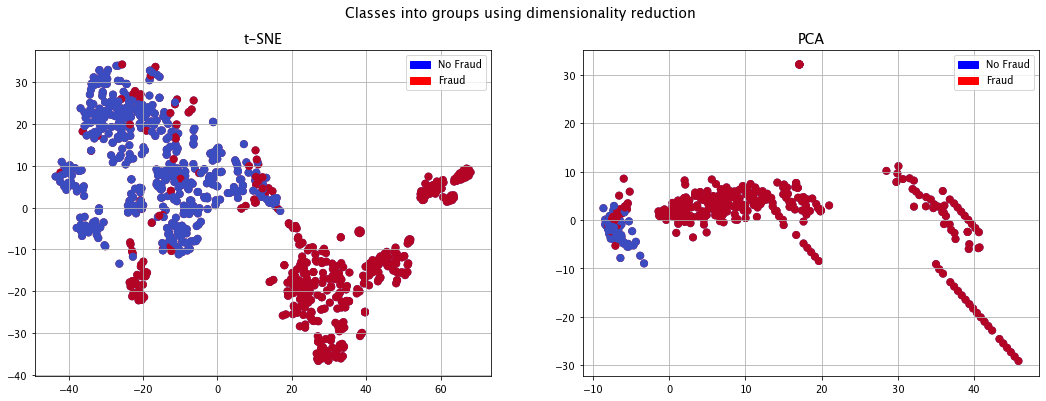

In [92]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 6))

f.suptitle("Classes into groups using dimensionality reduction", fontsize=14)
b_dot = mpatches.Patch(color = "b", label="No Fraud")
r_dot = mpatches.Patch(color = "r", label="Fraud")

# t-SNE plot
ax1.scatter(X_tsne[:,0], X_tsne[:,1], c=(y==0), cmap="coolwarm", label="No Fraud", linewidths=2)
ax1.scatter(X_tsne[:,0], X_tsne[:,1], c=(y==1), cmap="coolwarm", label="Fraud", linewidths=2)
ax1.set_title("t-SNE", fontsize=14)
ax1.grid(True)
ax1.legend(handles=[b_dot, r_dot])

# PCA plot
ax2.scatter(X_pca[:,0], X_pca[:,1], c=(y==0), cmap="coolwarm", label="No Fraud", linewidths=2)
ax2.scatter(X_pca[:,0], X_pca[:,1], c=(y==1), cmap="coolwarm", label="Fraud", linewidths=2)
ax2.set_title("PCA", fontsize=14)
ax2.grid(True)
ax2.legend(handles=[b_dot, r_dot])

plt.show()

Since, the dimensionality reductions methods can separate the two class well, then our predictive models should be able to learn how to classify a transaction as fraud or non-fraud.

In [93]:
new_usmpl_df.shape

(936, 31)

## Classifiers

In [94]:
X = new_usmpl_df.drop("Class", axis=1)
y = new_usmpl_df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [98]:
# Classifiers

classifiers = {
    "LogisticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "SVM": SVC(),
    "DecisionTree": DecisionTreeClassifier()
}

for key, classifier in classifiers.items():
    # classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: {} Has training score of {}% accuracy score".format(classifier.__class__.__name__, round(training_score.mean()*100, 2)))

Classifiers: LogisticRegression Has training score of 93.58% accuracy score
Classifiers: KNeighborsClassifier Has training score of 94.65% accuracy score
Classifiers: SVC Has training score of 93.98% accuracy score
Classifiers: DecisionTreeClassifier Has training score of 91.58% accuracy score


### Hyperparameter search:

In [163]:
# scorer
scorer = {"f1": make_scorer(f1_score)}

# for Logistic Regression
# for L2 penalty 
log_reg_params_l2 = {"penalty": ["l2"], "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg_l2 = GridSearchCV(LogisticRegression(), log_reg_params_l2, cv=5, scoring=scorer, refit="f1")
grid_log_reg_l2.fit(X_train, y_train)

# best hyperparameter settings
log_reg_l2 = grid_log_reg_l2.best_estimator_

# for L1 penalty (solver must be liblinear)
log_reg_params_l1 = {"penalty": ["l1"], "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg_l1 = GridSearchCV(LogisticRegression(solver="liblinear"), log_reg_params_l1, cv=5, scoring=scorer, refit="f1")
grid_log_reg_l1.fit(X_train, y_train)

# best hyperparameter settings
log_reg_l1 = grid_log_reg_l1.best_estimator_

grid_log_reg = grid_log_reg_l2 if grid_log_reg_l2.best_score_ > grid_log_reg_l1.best_score_ else grid_log_reg_l1
log_reg = log_reg_l2 if grid_log_reg_l2.best_score_ > grid_log_reg_l1.best_score_ else log_reg_l1

In [164]:
grid_log_reg_l1.cv_results_["mean_test_f1"]

array([0.        , 0.88081414, 0.93756497, 0.93204761, 0.93370514,
       0.93209099, 0.93209099])

In [165]:
# for knearest neighbor classifier
knears_params = {"n_neighbors": list(range(2,5,1)),
                "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params, cv=5, scoring=scorer, refit="f1")
grid_knears.fit(X_train, y_train)

# best knearest neighbor classifier
knears_neighbors = grid_knears.best_estimator_

In [166]:
# for support vector classifier
svc_params = {"C": [0.5, 0.7, 0.9, 1], "kernel": ["rbf", "poly", "sigmoid", "linear"]}
grid_svc = GridSearchCV(SVC(), svc_params, cv=5, scoring=scorer, refit="f1")
grid_svc.fit(X_train, y_train)

# best estimator
svc = grid_svc.best_estimator_

In [167]:
# for DecisionTree classifier
tree_params = {"criterion": ["gini", "entropy"],
                "max_depth": list(range(2,4,1)),
                "min_samples_leaf": list(range(5,7,1))}


grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, scoring=scorer, refit="f1")
grid_tree.fit(X_train, y_train)

# best estimator
tree_clf = grid_tree.best_estimator_

In [168]:
# getting the best hyperparameters for all the classifiers
print("Best Hyperparameters for the classifiers are:")
print("LogisticRegression Classifier: {}".format(grid_log_reg.best_params_))
print("KNearestNeighbor Classifier: {}".format(grid_knears.best_params_))
print("SVM Classifier: {}".format(grid_svc.best_params_))
print("DecisionTree Classifier: {}".format(grid_tree.best_params_))

Best Hyperparameters for the classifiers are:
LogisticRegression Classifier: {'C': 0.1, 'penalty': 'l2'}
KNearestNeighbor Classifier: {'algorithm': 'auto', 'n_neighbors': 3}
SVM Classifier: {'C': 0.5, 'kernel': 'linear'}
DecisionTree Classifier: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5}


In [170]:
# getting the best cross validation scores for all the classifiers
print("Best scores for the classifiers are:")
print("LogisticRegression Classifier: {}".format(max(grid_log_reg.cv_results_["mean_test_f1"])))
print("KNearestNeighbor Classifier: {}".format(max(grid_knears.cv_results_["mean_test_f1"])))
print("SVM Classifier: {}".format(max(grid_svc.cv_results_["mean_test_f1"])))
print("DecisionTree Classifier: {}".format(max(grid_tree.cv_results_["mean_test_f1"])))

Best scores for the classifiers are:
LogisticRegression Classifier: 0.9396574679644015
KNearestNeighbor Classifier: 0.9435419900244518
SVM Classifier: 0.934694861088355
DecisionTree Classifier: 0.9202855378528062


### Plotting ROC curves:

In [199]:
# predicting with classifiers and getting the decision function values
log_reg_pred = log_reg.decision_function(X_test)
knears_pred = knears_neighbors.predict_proba(X_test)[:,1]
svc_pred = svc.decision_function(X_test)
tree_clf_pred = tree_clf.predict_proba(X_test)[:,1]

# predicting the class of the test samples
log_reg_pred_cls = log_reg.predict(X_test)
knears_pred_cls = knears_neighbors.predict(X_test)
svc_pred_cls = svc.predict(X_test)
tree_clf_pred_cls = tree_clf.predict(X_test)

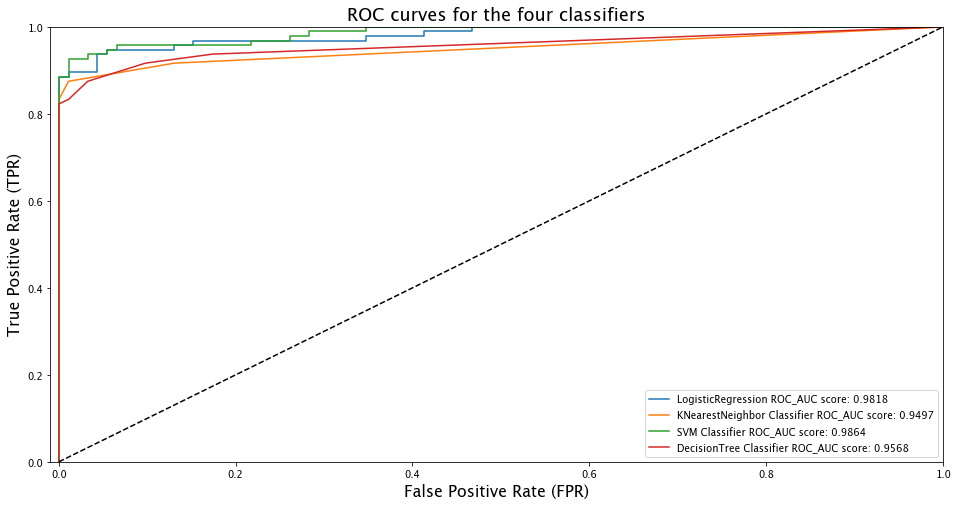

In [200]:
# creating ROC curves
log_fpr, log_tpr, log_threshold = roc_curve(y_test, log_reg_pred)
knears_fpr, knears_tpr, knears_threshold = roc_curve(y_test, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_test, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_test, tree_clf_pred)

plt.figure(figsize=(16, 8))
plt.title("ROC curves for the four classifiers", fontsize=18)
plt.plot(log_fpr, log_tpr, label="LogisticRegression ROC_AUC score: {0:.4f}".format(roc_auc_score(y_test, log_reg_pred)))
plt.plot(knears_fpr, knears_tpr, label="KNearestNeighbor Classifier ROC_AUC score: {0:.4f}".format(roc_auc_score(y_test, knears_pred)))
plt.plot(svc_fpr, svc_tpr, label="SVM Classifier ROC_AUC score: {0:.4f}".format(roc_auc_score(y_test, svc_pred)))
plt.plot(tree_fpr, tree_tpr, label="DecisionTree Classifier ROC_AUC score: {0:.4f}".format(roc_auc_score(y_test, tree_clf_pred)))
plt.plot([0,1], [0,1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.xlabel("False Positive Rate (FPR)", fontsize=16)
plt.ylabel("True Positive Rate (TPR)", fontsize=16)
plt.legend()
plt.show()

### Confusion Matrices:

In [220]:
# function to plot confusion matrix
def plot_confusion_matrix(cnf_mat, class_names, title, axis):
    cmap = plt.cm.Blues
    img = axis.imshow(cnf_mat, interpolation= 'nearest', cmap=cmap)
    axis.set_title(title, fontsize=14)
    plt.colorbar(img, ax=axis)
    tick_marks = np.arange(len(class_names))
    axis.set_xticks(tick_marks, class_names, rotation=0)
    axis.set_yticks(tick_marks, class_names)

    thresh = cnf_mat.max()/2.0
    for i, j in itertools.product(range(cnf_mat.shape[0]), range(cnf_mat.shape[1])):
        axis.text(j, i, cnf_mat[i, j],
                horizontalalignment='center',
                color="white" if cnf_mat[i,j] > thresh else "black")

    axis.set_ylabel("True Label")
    axis.set_xlabel("Predicted Label")


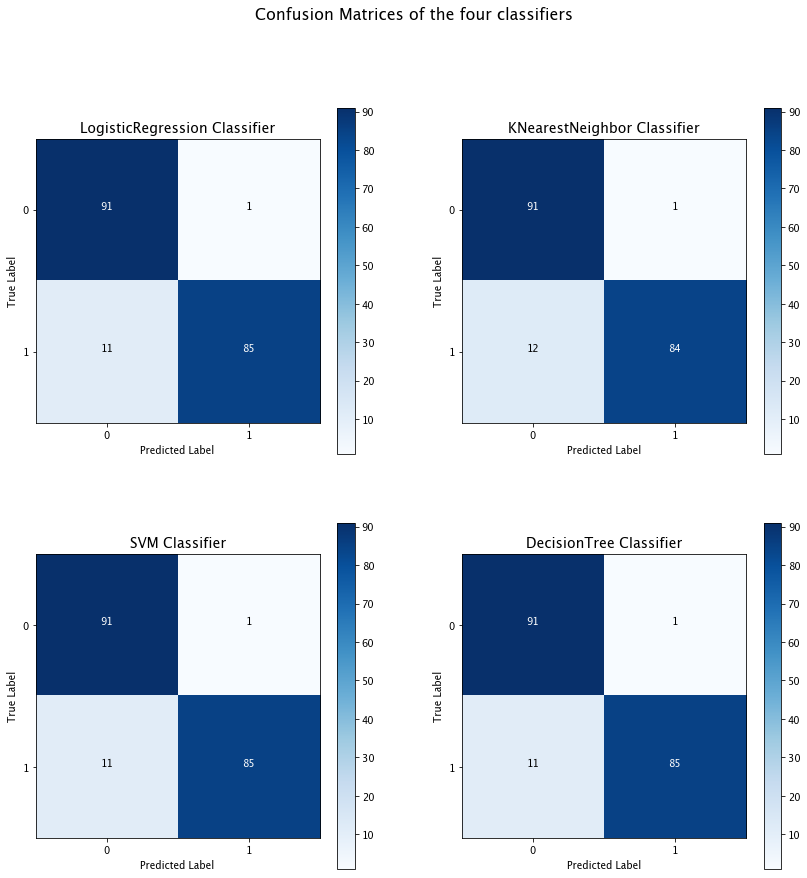

In [237]:

log_cnf_matrix = confusion_matrix(y_test, log_reg_pred_cls)
knears_cnf_matrix = confusion_matrix(y_test, knears_pred_cls)
svc_cnf_matrix = confusion_matrix(y_test, svc_pred_cls)
tree_cnf_matrix = confusion_matrix(y_test, svc_pred_cls)


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 14))
# f.tight_layout(h_pad=2, v_pad=2)
plot_confusion_matrix(log_cnf_matrix, class_names=[0,1], title="LogisticRegression Classifier", axis=ax1)
plot_confusion_matrix(knears_cnf_matrix, class_names=[0,1], title="KNearestNeighbor Classifier", axis=ax2)
plot_confusion_matrix(svc_cnf_matrix, class_names=[0,1], title="SVM Classifier", axis=ax3)
plot_confusion_matrix(tree_cnf_matrix, class_names=[0,1], title="DecisionTree Classifier", axis=ax4)
plt.suptitle("Confusion Matrices of the four classifiers", fontsize=16)
plt.show()